# Neural Networks & Deep Learning
在这一节中，我们将构建一个三层的神经网络来处理手写数字识别问题，之后我们将运用AdaGrad、RMSprop、Momentum、Nesterov Momentum和Adam优化算法来加速梯度下降的过程，首先我们先来实现一个简单的神经网络。 


欢迎同学们观看哔哩哔哩 《数之道》相关视频 提升自己对于机器学习的理解 https://www.bilibili.com/video/BV12b4y1X7Wv/?spm_id_from=333.788&vd_source=2dbf3ce169def83a8e8b53329f7d2135

## 1. 导入所需的Python库

In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from utils import load_mnist

In [2]:
from collections import OrderedDict

## 2. 加载数据并可视化

先介绍一下在这个实验中所用到的数据库MNIST，MNIST数据集是一个手写体数据集，其中每个手写数字是一张28×28的灰度图片，图片的标记为一个0-9表示的数字。  MNIST数据集一共有60000张图片用来作为训练集，10000张图片来作为测试集。  
我们知道一张灰度图片一般是二维的，但是神经网络中的全连接层的输入是一个一维的向量。所以我们需要将一张二维的灰度图片“压扁”成一个一维的向量，具体如下图所示：
<img src="./images/2d_to_1d.jpg" width="300" height="300" alt="2d_to_1d" align=center>

因此每一个样本都是一个784维（即行24维*列24维）的向量。 

在处理多分类任务时，我们可以使用softmax来进行处理，这里的手写数字识别任务就是一个多分类任务，共包含有10类，分别用数字0-9表示，而在softmax中，每一类可以表示为一个向量，所以我们需要将类对应的符号标记转化成一个向量表示，这就是one-hot向量，比如，在手写数字识别中，数字0和1对应的one-hot向量分别为： 
$$one-hot(0)=\begin{bmatrix}1 \\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{bmatrix},one-hot(1)=\begin{bmatrix}0 \\ 1\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{bmatrix}$$ 
在训练集中，我们需要把样本的标记$Y$转化为one-hot向量。 

In [3]:
#加载训练集或测试集
path = './MNIST Data' #数据集文件所在目录
# 加载训练集合测试集
# 设置normalization为True，将数据缩放到[0,1]之间
# 设置one_hot_label为True，将标签转化为one_hot向量
(x_train, y_train), (x_test, y_test) = load_mnist(path, normalize=True, one_hot_label=True)

In [4]:
print('The shape of X_train is:',x_train.shape)
print('The shape of Y_train is:',y_train.shape)
print('The shape of X_test is:',x_test.shape)
print('The shape of Y_test is:',y_test.shape)

The shape of X_train is: (60000, 784)
The shape of Y_train is: (60000, 10)
The shape of X_test is: (10000, 784)
The shape of Y_test is: (10000, 10)


下面在训练集中选取几个图片看一下。

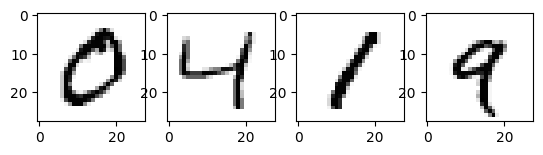

one hot 标签： [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
对应的实际标签： 0 4 1 9


In [5]:
fig = plt.figure()

ax1 = fig.add_subplot(141)
ax1.imshow(x_train[1,:].reshape(28, 28), cmap='Greys')
ax2 = fig.add_subplot(142)
ax2.imshow(x_train[2,:].reshape(28,28), cmap='Greys')
ax3 = fig.add_subplot(143)
ax3.imshow(x_train[3,:].reshape(28,28), cmap='Greys')
ax4 = fig.add_subplot(144)
ax4.imshow(x_train[4,:].reshape(28,28), cmap='Greys')
plt.show()
print('one hot 标签：',y_train[1,:],y_train[2,:],y_train[3,:],y_train[4,:])
print('对应的实际标签：',np.argmax(y_train[1,:]),np.argmax(y_train[2,:]),np.argmax(y_train[3,:]),np.argmax(y_train[4,:]))

## 3. 全连接神经网络

接下来，我们来搭建一个三层全连接神经网络。网络结构如右图所示：
<img src="./images/network_architecture.jpg" width="500" height="250" alt="network_architecture" align=center>

对公式所用符号的说明：  
一般算神经网络层数不算输入层，所以上图只有3层。用右上角的方括号表示相应的层，所有第1层的权重$W$为$W^{[1]}$，第1层的偏置项$b$为$b^{[1]}$(图中未标出)，第1层的激活值$A$为$A^{[1]}$。  

前两层的激活函数使用LeakyRelu，最后一层使用Softmax进行分类

### 3.1 初始化网络参数

我们规定第1层的神经元个数为300，第二层个数为300，最后一层为10.输入向量$X$的维度为784，那么整个网络对应的参数也就可以确定了。  
$W^{[1]}$的shape为$(784,300)$，$b^{[1]}$的shape为$(300,)$  
$W^{[2]}$的shape为$(300,300)$，$b^{[2]}$的shape为$(300,)$  
$W^{[3]}$的shape为$(300,10)$，$b^{[3]}$的shape为$(10,)$  
这里使用随机正态分布再乘上比例因子0.01来初始化$W$， 对$b$都初始化为0.  
**Hint**: 使用`np.random.randn()`,`np.zeros()`  


In [6]:
def initialize_parameters(input_size, hidden_size, output_size, weight_init_std):
    """
    @param input_size:输入向量维度
    @param hidden_size:中间神经元个数
    @param output_size:输出层神经元个数
    @param weight_init_sta:比例因子
    """
    np.random.seed(1)
    params = {}

    params['W1'] = np.random.randn(input_size,hidden_size) * weight_init_std
    params['b1'] = np.zeros((hidden_size,)) #请参考样例完成代码
    ### START CODE HERE ### 
    params['W2'] = np.random.randn(hidden_size,hidden_size) * weight_init_std
    params['b2'] = np.zeros((hidden_size,))
    params['W3'] = np.random.randn(hidden_size,output_size) * weight_init_std
    params['b3'] = np.zeros((output_size,))
    
    ### END CODE HERE ### 

    print("W1's shape:",params['W1'].shape)
    print("b1's shape:",params['b1'].shape)
    print("W2's shape:",params['W2'].shape)
    print("b2's shape:",params['b2'].shape)
    print("W3's shape:",params['W3'].shape)
    print("b3's shape:",params['b3'].shape) #请在调用该函数的地方观察该神经网络各个参数的shape，是否符合预期
    
    return params

In [7]:
# initialize_parameters(784,300,10,0.01)

### 3.2 定义神经网络的每一层
我们将构成神经网络的层实现为一个单独的类

我们先来实现LeakyRelu层

#### LeakyRelu层

激活函数LeakyRelu的表达式为：
$$
\left\{\begin{matrix}
x & (x>0)\\ 
\alpha x & (x \leq 0)
\end{matrix}\right.
$$
可以通过上式求出y关于x的导数：
$$
\frac{\partial y}{\partial x} = \left\{\begin{matrix}
1 & (x>0)\\ 
\alpha & (x \leq 0)
\end{matrix}\right.
$$

如果正向传播时的输入x大于0，则反向传播会将下游的值原封不动地传给上游。反过来，如果正向传播时的x小于等于0，则反向传播中传给上游的信号将乘上一个很小的常数，保证neuron依然起作用。
<img src="./images/LeakyReLu.png" width="350" height="250" alt="ReLU" align=center>


In [8]:
class LeakyRelu:
    def __init__(self):
        self.mask = None 
        self.alpha = 0.1
        
    def forward(self, x):
        self.mask = (x <= 0) #mask表示选择出x的值中小于等于0的部分内容
        ## self.mask2=(x>0)
        out = x.copy()
        ### START CODE HERE ###  #请参考LeakyRelu表达式实现前向传播过程
        out[self.mask] = out[self.mask]*self.alpha
        ### END CODE HERE ### 
        return out

    def backward(self, dout):
        ### START CODE HERE ###  #请参考LeakyRelu表达式y关于x的导数公式实现反向传播过程
        dout[self.mask] = self.alpha*dout[self.mask]
        ### END CODE HERE ### 
#         dx = dout
        return dout

测试一下效果

In [9]:
leakyRelu = LeakyRelu()
x = np.array( [[1.0, -0.5], [-2.0, 3.0]] )
leakyRelu.forward(x), leakyRelu.backward(x)

(array([[ 1.  , -0.05],
        [-0.2 ,  3.  ]]),
 array([[ 1.  , -0.05],
        [-0.2 ,  3.  ]]))

#### Affine层

神经网络的正向传播中，为了计算加权信号的总和，使用了矩阵的乘积运算，回顾一下公式：
$$
Y = XW + B
$$
即`Y = np.dot(X, W) + B`  
假设X,W,B的形状分别为(2,)、(2,3)、(3,)
<img src="./images/Affine1.png" align=center>
现在将这里进行的求矩阵的乘积与偏置的和的运算用计算图表示出来。将乘积运算用“dot”节点表示的话，则np.dot(X, W) + B的运算如图所示：
<img src="./images/Affine2.png" align=center>

以矩阵为对象的反向传播，按矩阵的各个元素进行计算时，步骤和以标量为对象的计算图相同。实际写
一下的话，可以推导得到：
$$
\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot W^T
$$
  
$$
\frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial Y}
$$
根据这个式子我们可以写出计算图的反向传播：
<img src="./images/Affine3.png" align=center >

前面介绍的Affine层的输入是以单个数据为对象的，现在我们考虑N个数据一起进行正向传播，计算图如下：
<img src="./images/Affine4.png" align=center >
与刚刚不同的是，现在输入X的形状是(N, 2)。之后就和前面一样，在计算图上进行单纯的矩阵计算。反向传播时，如果注意矩阵的形状，就可以和前面一样推导出$\frac{\partial L}{\partial X}$和$\frac{\partial L}{\partial W}$。

In [10]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        ### START CODE HERE ### 
        out = np.dot(self.x,self.W)+self.b 
        ##print(out)
        ### END CODE HERE ### 
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        ### START CODE HERE ### 
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis=0)
        ### END CODE HERE ### 
        
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx

#### Softmax-with-Loss层

softmax函数会将输入值正规化后输出，如图所示：
<img src="./images/softmax.png" align=center>
具体公式为
$$softmax(x_i)=\frac{e^{x_i}}{\sum_{j=1}^{C}{e^{x_j}}}$$ 
$x_i$表示为向量$x$的第$i$个分量。  $softmax$函数这里直接给出

In [11]:
def softmax(x):
    x = x.T
    x = x - np.max(x, axis=0)
#     mu=np.mean(x,axis=0)
#     sigma=np.std(x,axis=0)
#     sigma=np.clip(sigma, 1e-6, max(sigma))
#     x=(x-mu)/sigma
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T 

In [12]:
x=np.array([[1.0, -0.5], [-2.0, 3.0]])
softmax(x)
# np.max(x,axis=0)
# x

array([[0.81757448, 0.18242552],
       [0.00669285, 0.99330715]])

在softmax中，我们一般使用的损失函数为交叉熵函数：  
$$L(\hat{y},y)=-\sum_{j=1}^{C}{y_jlog\hat{y_j}}$$  
其中，$C$是类别的数量，在本次实验中即为10.  
成本函数为：  
$$J(W^{[1]},b^{[1]},...)=\frac{1}{m}\sum_{i=1}^{m}{L(\hat{y}^{(i)},y^{(i)})}$$  
这里$m$是mini-batch的大小。因为训练集有60000个，我们不能直接把$(60000,784)$大小的输入直接放入神经网络计算。因此，每次就选择一部分来进行前向传播，所以输入的大小是$(m,784)$.
**Hint**: 最后的Loss是个标量 

In [13]:
def cross_entropy_error(pred, y):
    if pred.ndim == 1:
        y = y.reshape(1, y.size)
        pred = pred.reshape(1, pred.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if y.size == pred.size:
        y = y.argmax(axis=1)
             
    batch_size = pred.shape[0]
    
    res = None

    res = -np.sum(np.log(pred[:, y] + 1e-7)) / batch_size
    
    return res

下面来实现Softmax 层。考虑到这里也包含作为损失函数的交叉熵误差（cross entropy error），所以称为“Softmax-with-Loss 层”。Softmax-with-Loss 层（Softmax函数和交叉熵误差）的计算图如图所示。
<img src="./images/softmax-cross.png" align=center>

可以看到，Softmax-with-Loss 层有些复杂。这里只给出了最终结果。

In [14]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.pred = None # softmax的输出
        self.y = None # 监督数据

    def forward(self, x, y):
        self.y = y
        self.pred = softmax(x)
        self.loss = cross_entropy_error(self.pred, self.y)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        if self.y.size == self.pred.size: # 监督数据是one-hot-vector的情况
            dx = (self.pred - self.y) / batch_size
        else:
            dx = self.pred.copy()
            dx[np.arange(batch_size), self.y] -= 1
            dx = dx / batch_size
        
        return dx

### 3.3 搭积木
现在我们把之前的每一层组合在一起就能搭成我们自己的三层神经网络了。
神经网络学习的步骤大致有5步：
1. 初始化权重
2. 随机选择一部分数据
3. 计算梯度
4. 更新参数
5. 重复步骤2,3,4


In [15]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        
        # 初始化权重
        self.params = initialize_parameters(input_size, hidden_size, output_size, weight_init_std)
        # 记录训练次数 adam里要用
        self.t = 0

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['LeakyRelu1'] = LeakyRelu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['LeakyRelu2'] = LeakyRelu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
    
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        # 前向传播
        pred = x.copy()
        for layer in self.layers.values():
            # 通过forward函数完成前向传播
            ### START CODE HERE ###
            pred = layer.forward(pred) #对每一层进行前向传播预测结果
            ### END CODE HERE ###
            
        return pred
        
    def loss(self, x, y):
        # 计算交叉熵损失
        ### START CODE HERE ### 
        pred = self.predict(x) #计算关于x的预测结果
        loss = self.lastLayer.forward(pred,y) #使用SoftmaxWithLoss层计算预测结果和y之间的交叉熵损失
        ### END CODE HERE ### 
        return loss
    
    def accuracy(self, x, y):
        # 输入数据x和标签y，输出当前神经网络的预测准确率
        accuracy = None
        pred = self.predict(x)
        pred = np.argmax(pred, axis=1)
        if y.ndim != 1:
            y = np.argmax(y, axis=1)
        
        accuracy = np.sum(pred == y) / float(x.shape[0])

        return accuracy
        
    def gradient(self, x, y):
        # 前向传播
        self.loss(x, y)

        # 反向传播
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        
        return grads

### 3.4 进行训练

首先定义参数更新函数

In [16]:
def update_parameters(network, grads, learning_rate=0.001):
    """
    使用梯度下降法更新network的参数
    """

    #在这里我们给出了最基础的梯度下降法更新网络参数的实现代码，请同学们参考并完成其他优化算法的代码
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grads[key]  #在network现在的参数基础上减去学习率*梯度
    
    return 

然后定义训练函数

In [17]:
def train_network(network, update_params_method, iters_num, train_size, batch_size, learning_rate):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)

    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = y_train[batch_mask]
        network.t += 1
        # 计算梯度
        grad = network.gradient(x_batch, t_batch)

        # 更新梯度
        update_params_method(network, grad, learning_rate)

        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, y_train)
            test_acc = network.accuracy(x_test, y_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print("Train acc:{:<.6f}\tTest acc:{:<.6f}".format(train_acc, test_acc))

In [18]:
# 读入数据
(x_train, y_train), (x_test, y_test) = load_mnist(path, normalize=True, one_hot_label=True)

In [19]:
# 定义神经网络
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [20]:
iters_num = 10000 #迭代次数
train_size = x_train.shape[0] #训练集的样本数量
batch_size = 100 #batch大小
learning_rate = 0.1 #学习率
train_network(network, update_parameters, iters_num, train_size, batch_size, learning_rate) #开始训练网络

Train acc:0.085400	Test acc:0.084700
Train acc:0.882817	Test acc:0.887600
Train acc:0.921217	Test acc:0.918800
Train acc:0.941400	Test acc:0.940300
Train acc:0.954433	Test acc:0.953100
Train acc:0.966600	Test acc:0.961500
Train acc:0.972000	Test acc:0.965700
Train acc:0.975467	Test acc:0.967000
Train acc:0.978200	Test acc:0.970800
Train acc:0.982183	Test acc:0.972900
Train acc:0.985733	Test acc:0.977900
Train acc:0.986983	Test acc:0.976200
Train acc:0.986350	Test acc:0.974700
Train acc:0.989633	Test acc:0.977500
Train acc:0.991583	Test acc:0.978200
Train acc:0.992133	Test acc:0.978600
Train acc:0.990667	Test acc:0.977800


### 3.5 梯度下降优化算法
下面回顾几种上课讲过的优化算法，注意它们之间的差异与联系。

#### 3.5.1AdaGrad  

当$J(\theta)$收敛到最低值附近时，因为步长$\alpha$大小固定的原因，$J(\theta)$会在最低值附近徘徊，而不能到达最低值。因此，AdaGrad的想法是随着迭代次数的增加降低学习率$\alpha$，学习率$\alpha$衰减的方式是
$$
\alpha^t = \frac{\alpha}{\sqrt{t+1}}
$$
其中t表示第t次迭代。

如果梯度数值小，$J(\theta)$的移动步长小，$J(\theta)$在坡度平缓的区域内下降速度会变慢。AdaGrad使用均方根来加快$J(\theta)$在平缓区域的下降速度。均方根的表示为
$$
\sigma^t = \sqrt{\frac{1}{t+1} \sum_{i=0}^{t}(g^i)2}
$$
其中$g^i$表示历史的梯度值。AdaGrad 的更新参数公式是
$$
\begin{aligned}
\theta^{t+1} & := \theta^t - \frac{\alpha^t}{\sigma^t} g^t \\
& := \theta^t - \frac{\alpha}{\sqrt{\sum_{i=0}^t (g^i)^2}} g^t
\end{aligned}
$$
在坡度平缓的区域，均方根的数值小，梯度除以一个数值小的数会变大，从而加大了$J(\theta)$移动步长，也因此加快梯度下降速度。但是，AdaGrad的缺点是，随着迭代次数的增大，均方根会越来越大，梯度趋近于0，导致训练提前停止。为了防止分母为0，我们给分母加上一个小数值$\epsilon =10^{-7}$。
$$
\theta^{t+1} := \theta^t - \frac{\alpha}{\sqrt{\sum_{i=0}^t (g^i)^2} + \epsilon} g^t
$$

我们可以看到分母里会计算所有历史梯度值的平方和，所以在实现的时候不用保存所有的历史梯度值，只需要保存一个纪录所有历史梯度平方和的值即可。每个参数的历史梯度和初始值为0。   
在代码实现中，我们使用`epsilon`代表ε  

In [21]:
def initialize_grads_squared(network):
    """
    初始化历史梯度和
    """
    grads_squared = {}
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        
        grads_squared[key] = np.zeros(network.params[key].shape)
        
    return grads_squared

In [22]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
grads_squared = initialize_grads_squared(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [23]:
def update_parameters_with_adagrad(network, grads, learning_rate=0.001, epsilon = 1e-7):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #计算历史梯度平方和
        grads_squared[key] += np.sum(grads[key]**2)   
        network.params[key] -= learning_rate*grads[key]/(np.sqrt(grads_squared[key])+epsilon)
        ### END CODE HERE ###
        
    return 

In [24]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 1
train_network(network, update_parameters_with_adagrad, iters_num, train_size, batch_size, learning_rate)

Train acc:0.098633	Test acc:0.095800
Train acc:0.922817	Test acc:0.926200
Train acc:0.940583	Test acc:0.939200
Train acc:0.951233	Test acc:0.949500
Train acc:0.957633	Test acc:0.955500
Train acc:0.962617	Test acc:0.959300
Train acc:0.965750	Test acc:0.962600
Train acc:0.969400	Test acc:0.965000
Train acc:0.970467	Test acc:0.967600
Train acc:0.973583	Test acc:0.968100
Train acc:0.975250	Test acc:0.970700
Train acc:0.976500	Test acc:0.970200
Train acc:0.977533	Test acc:0.971900
Train acc:0.979133	Test acc:0.972300
Train acc:0.980567	Test acc:0.971900
Train acc:0.980683	Test acc:0.972000
Train acc:0.981983	Test acc:0.974800


#### 3.5.2 RMSprop  

从AdaGrad算法的公式可看出，所有时刻的梯度都对当前的参数更新有影响。如果早先的梯度并不是一个正确的方向，那么这些糟糕的梯度还是会影响到当前的参数更新。因此，RMSprop相当于就是只记录当前时刻前的某一段历史梯度和而不是所有历史梯度和。  
RMSprop算法的公式如下：  
$$
 u^0 = 0 \\
 u^{t+1} = \rho u^t + (1-\rho) [\nabla J(\theta ^t)]^2 \\ 
 \theta^{t+1} = \theta^t - \frac{\alpha}{\sqrt{u^{t+1}}+\epsilon}\nabla J(\theta ^t) 
$$
这里$\rho$是超参数，一般设为0.999，也不会调它。$\epsilon$是防止分母为0。另外值得注意的是，因为要整合这几个算法在一起，而Adam算法又融合了各种算法，所以，关于优化算法的超参数的命名与Adam里保持一致，公式里的$\rho$用下面参数`beta`代替。这些算法几乎都要保存一些变量，它们的初始化基本与AdaGrad初始化的方法一致，所以这部分初始化的代码就不重复了。  

In [25]:
def update_parameters_with_rmsprop(network, grads, learning_rate=0.001, epsilon = 1e-7, beta=0.999):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #公式里的u就是这里的 grads_squared         
        grads_squared[key] = beta*grads_squared[key]+(1-beta)*(grads[key]**2)
        network.params[key] -=  learning_rate*grads[key]/(np.sqrt(grads_squared[key])+epsilon)
        
        ### END CODE HERE ###
    return 

In [26]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
grads_squared = initialize_grads_squared(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [27]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_rmsprop, iters_num, train_size, batch_size, learning_rate)

Train acc:0.154500	Test acc:0.145600
Train acc:0.964933	Test acc:0.959300
Train acc:0.975267	Test acc:0.968700
Train acc:0.984133	Test acc:0.973400
Train acc:0.987083	Test acc:0.975700
Train acc:0.988967	Test acc:0.975400
Train acc:0.992717	Test acc:0.977400
Train acc:0.994050	Test acc:0.977900
Train acc:0.993700	Test acc:0.978300
Train acc:0.993617	Test acc:0.976400
Train acc:0.993650	Test acc:0.976300
Train acc:0.993333	Test acc:0.976200
Train acc:0.995350	Test acc:0.980400
Train acc:0.996850	Test acc:0.979400
Train acc:0.996750	Test acc:0.978900
Train acc:0.994883	Test acc:0.975800
Train acc:0.994900	Test acc:0.978100


#### 3.5.3 Momentum

动量梯度下降（Gradient Descent with Momentum）基本思想就是计算梯度的指数加权平均数，并利用该指数加权平均数更新权重。具体过程为：
$$
v^0 = 0 \\
v^{t+1}  = \rho v^t +\alpha \nabla J(\theta ^t) \\
\theta^{t+1} = \theta ^t - v^{t+1}
$$

这里的$\rho$一般取0.9。 

In [28]:
def initialize_velocity(network):
    v = {}
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        v[key] = np.zeros((network.params[key]).shape) 
    return v

In [29]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v = initialize_velocity(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [30]:
def update_parameters_with_momentum(network, grads, learning_rate=0.001, beta=0.9):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #公式里的u就是这里的 grads_squared         
        v[key] = beta*v[key]+learning_rate*grads[key]
        network.params[key] -= v[key]
        
        ### END CODE HERE ###
    return 

In [31]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
# learning_rate = 0.001
learning_rate = 0.1
train_network(network, update_parameters_with_momentum, iters_num, train_size, batch_size, learning_rate)

Train acc:0.085400	Test acc:0.084700
Train acc:0.958250	Test acc:0.951500
Train acc:0.973567	Test acc:0.966100
Train acc:0.981533	Test acc:0.971600
Train acc:0.984467	Test acc:0.974900
Train acc:0.985900	Test acc:0.973600
Train acc:0.987750	Test acc:0.973000
Train acc:0.992167	Test acc:0.979600
Train acc:0.992700	Test acc:0.978100
Train acc:0.992617	Test acc:0.979300
Train acc:0.992067	Test acc:0.978800
Train acc:0.994917	Test acc:0.980300
Train acc:0.991500	Test acc:0.977000
Train acc:0.995667	Test acc:0.980700
Train acc:0.996067	Test acc:0.980300
Train acc:0.997450	Test acc:0.981500
Train acc:0.997000	Test acc:0.978900


#### 3.5.4 Nesterov Momentum  

Nesterov Momentum算法与Momentum不同的是在于，它会提前计算一个在速度作用后的梯度。具体算法如下：
$$
v^{t+1} = \rho v^t + \alpha \nabla J(\theta ^t - \rho v^t) \\
\theta^{t+1} = \theta ^t - v^{t+1}
$$
但是在实现的时候，我们是不会算一次$J(\theta ^t)$再算一次$\nabla J(\theta ^t - \rho v^t)$的。具体编程实现时上式等价于下式：
$$
 v^{t+1} = \rho v^t + \alpha \nabla J(\theta ^t) \\
 \theta^{t+1} = \theta ^t - \rho v^{t+1} - \alpha \nabla J(\theta ^t)
$$
这里的$\rho$一般取0.9。  

In [32]:
def update_parameters_with_nesterov_momentum(network, grads, learning_rate=0.001, beta=0.9):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
                
        v[key] = beta*v[key]+learning_rate*grads[key]
        network.params[key] -= beta*v[key]-learning_rate*grads[key]
        
        ### END CODE HERE ###
    return 

In [33]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v = initialize_velocity(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [34]:
iters_num = 20000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_nesterov_momentum, iters_num, train_size, batch_size, learning_rate)

Train acc:0.085067	Test acc:0.083600
Train acc:0.112367	Test acc:0.113500
Train acc:0.152900	Test acc:0.153700
Train acc:0.274200	Test acc:0.276800
Train acc:0.530750	Test acc:0.538100
Train acc:0.725900	Test acc:0.736700
Train acc:0.784300	Test acc:0.791900
Train acc:0.811433	Test acc:0.817700
Train acc:0.839900	Test acc:0.844500
Train acc:0.859333	Test acc:0.862100
Train acc:0.871667	Test acc:0.872600
Train acc:0.881017	Test acc:0.881600
Train acc:0.886933	Test acc:0.887300
Train acc:0.892533	Test acc:0.890900
Train acc:0.897700	Test acc:0.895600
Train acc:0.900600	Test acc:0.898500
Train acc:0.903950	Test acc:0.901800
Train acc:0.906467	Test acc:0.904700
Train acc:0.909183	Test acc:0.909400
Train acc:0.911567	Test acc:0.912400
Train acc:0.914733	Test acc:0.912700
Train acc:0.916433	Test acc:0.915800
Train acc:0.918800	Test acc:0.918300
Train acc:0.920517	Test acc:0.920700
Train acc:0.922817	Test acc:0.923100
Train acc:0.924517	Test acc:0.924400
Train acc:0.926150	Test acc:0.926100
T

#### 3.5.5 Adam

Adam优化算法（Adaptive Moment Estimation）是将Momentum和RMSprop结合在一起的算法，具体过程如下
$$
u^0 = 0 \\
v^0 = 0 \\
u^{t+1}  = \rho_2 u^t +(1-\rho_2) [\nabla J(\theta ^t)]^2 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{u^{t+1}}+\epsilon}v^{t+1}
$$
从上式可以看到，在最开始更新时，$u^{t},v^{t}$都是很小的。所以需要对早期的更新进行一个bias correction。完整公式如下
$$
u^0 = 0 \\
v^0 = 0 \\
u^{t+1}  = \rho_2 u^t +(1-\rho_2) [\nabla J(\theta ^t)]^2 \\
u^{t+1}_{corrected} = \frac{u^{t+1}}{1-\rho_2^t} \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
v^{t+1}_{corrected} = \frac{v^{t+1}}{1-\rho_1^t} \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{u^{t+1}_{corrected}}+\epsilon}v^{t+1}_{corrected}
$$

其中，一般设$\rho_1=0.9,\rho_2=0.999$.$\epsilon$也是防止分母过小或等于0.  

In [35]:
def initialize_adam(network) :
    v = {}
    u = {}

    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        v[key] = np.zeros(np.shape(network.params[key]))
        u[key] = np.zeros(np.shape(network.params[key]))
            
    return v, u

In [36]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v, u = initialize_adam(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [37]:
def update_parameters_with_adam(network, grads, learning_rate=0.001, epsilon=1e-7, beta1=0.9, beta2=0.999):
    v_corrected = {}
    u_corrected = {} 
    t = network.t #当前迭代次数
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
                
        v[key] = beta1*v[key]+(1-beta1)*grads[key]
        v_corrected[key] = v[key]/(1-beta1**t)
        
        u[key] = beta2*u[key]+(1-beta2)*(grads[key]**2)
        u_corrected[key] = u[key]/(1-beta2**t)
        
        network.params[key] -= learning_rate*v_corrected[key]/(np.sqrt(u_corrected[key])+epsilon)
        
        ### END CODE HERE ###
    return 

In [38]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_adam, iters_num, train_size, batch_size, learning_rate)

Train acc:0.224533	Test acc:0.221600
Train acc:0.958133	Test acc:0.953100
Train acc:0.970867	Test acc:0.964800
Train acc:0.978633	Test acc:0.970000
Train acc:0.984967	Test acc:0.973300
Train acc:0.988683	Test acc:0.975400
Train acc:0.988317	Test acc:0.974400
Train acc:0.991367	Test acc:0.978500
Train acc:0.993367	Test acc:0.978900
Train acc:0.994150	Test acc:0.979700
Train acc:0.994183	Test acc:0.980300
Train acc:0.995317	Test acc:0.978300
Train acc:0.994967	Test acc:0.977900
Train acc:0.993133	Test acc:0.978300
Train acc:0.995517	Test acc:0.978300
Train acc:0.995717	Test acc:0.979600
Train acc:0.995233	Test acc:0.977400


#### 3.5.6 AdaBelief

Adam优化算法中，梯度更新的方向是 $\frac{v_{t+1}}{\sqrt{u_{t+1}}}$, 其中 $u_{t+1}$ 是 $[\nabla J(\theta ^t)]^2$ 的指数移动平均(exponential moving average,EMA)。

AdaBelief优化算法将梯度方向改为了 $\frac{v_{t+1}}{\sqrt{s_{t+1}}}$, 其中 $s_{t+1}$ 是 $[\nabla J(\theta ^t)-v_{t}]^2$ 的指数移动平均，AdaBelief的算法过程具体如下：
$$
s^0 = 0 \\
v^0 = 0 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
s^{t+1}  = \rho_2 s^t +(1-\rho_2) [\nabla J(\theta ^t)-v_{t+1}]^2 \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{s^{t+1}}+\epsilon}v^{t+1}
$$

与Adam优化算法同理，从上式可以看到，AdaBelief优化算法在最开始更新时，$s^{t},v^{t}$都是很小的。所以需要对早期的更新进行一个bias correction。完整公式如下
$$
s^0 = 0 \\
v^0 = 0 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
v^{t+1}_{corrected} = \frac{v^{t+1}}{1-\rho_1^t} \\
s^{t+1}  = \rho_2 s^t +(1-\rho_2) [\nabla J(\theta ^t)-v_{t+1}]^2 \\
s^{t+1}_{corrected} = \frac{s^{t+1}}{1-\rho_2^t} \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{s^{t+1}_{corrected}}+\epsilon}v^{t+1}_{corrected}
$$

其中，一般设$\rho_1=0.9,\rho_2=0.999$.$\epsilon$也是防止分母过小或等于0. 

In [39]:
def initialize_adambelief(network) :
    v = {}
    s = {}

    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ###  #请初始化v和s
        v[key] = np.zeros(np.shape(network.params[key]))
        s[key] = np.zeros(np.shape(network.params[key]))
        ### END CODE HERE ###
            
    return v, s

In [40]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v, s = initialize_adambelief(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [41]:
def update_parameters_with_adambelief(network, grads, learning_rate=0.001, epsilon=1e-7, beta1=0.9, beta2=0.999):
    v_corrected = {}
    s_corrected = {} 
    t = network.t #当前迭代次数
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
                
        v[key] = beta1*v[key]+(1-beta1)*grads[key]
        v_corrected[key] = v[key]/(1-beta1**t)
        
        s[key] = beta2*s[key]+(1-beta2)*((grads[key]-v[key])**2)
        s_corrected[key] = s[key]/(1-beta2**t)
        
        network.params[key] -= learning_rate*v_corrected[key]/(np.sqrt(s_corrected[key])+epsilon)
        
        ### END CODE HERE ###
    return 

In [42]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_adambelief, iters_num, train_size, batch_size, learning_rate)

Train acc:0.229883	Test acc:0.226300
Train acc:0.960717	Test acc:0.955500
Train acc:0.970600	Test acc:0.965000
Train acc:0.979550	Test acc:0.968900
Train acc:0.985500	Test acc:0.974000
Train acc:0.987800	Test acc:0.976200
Train acc:0.989600	Test acc:0.974900
Train acc:0.991533	Test acc:0.977100
Train acc:0.990117	Test acc:0.976700
Train acc:0.993717	Test acc:0.979300
Train acc:0.993467	Test acc:0.979100
Train acc:0.994500	Test acc:0.979400
Train acc:0.992783	Test acc:0.974000
Train acc:0.996283	Test acc:0.978900
Train acc:0.996767	Test acc:0.979300
Train acc:0.995900	Test acc:0.978500
Train acc:0.997050	Test acc:0.981200


## 4. 总结
本次实验完整搭建了一个三层的全连接网络，使用了各种梯度更新优化算法训练MNIST数据集。  
或许你可以试试通过调整网络参数和超参数再把准确度提高一点？（记得记录每次训练时的数据结果）